<a href="https://colab.research.google.com/github/RushiaKawaii693/Test/blob/main/3_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pymysql sqlalchemy pandas python-dotenv numpy matplotlib seaborn datetime

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
from scipy import stats
from datetime import datetime
import os
from dotenv import load_dotenv
import warnings
warnings.filterwarnings('ignore')
from itertools import combinations

In [ ]:
# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

In [ ]:
# Load environment variables
load_dotenv('test.env')

True

In [ ]:
DB_HOST = os.getenv('DB_HOST')
DB_USER = os.getenv('DB_USER')
DB_PASSWORD = os.getenv('DB_PASSWORD')
DB_NAME = os.getenv('DB_NAME')
DB_TABLE = os.getenv('DB_TABLE')
DB_USER

'ahistudent'

In [ ]:
url_string = f"mysql+pymysql://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:3306/{DB_NAME}"

In [ ]:
conn = create_engine(url_string)


Available Teams:
                                                                                                                                  team  athlete_count
                                                                                                                              Football            136
                                                                                                                               Unknown            103
                                                                                                                       Mens Basketball             99
                                                                                                                              Mens Lax             94
                                                                                                                      Women's Lacrosse             82
                                                                                  

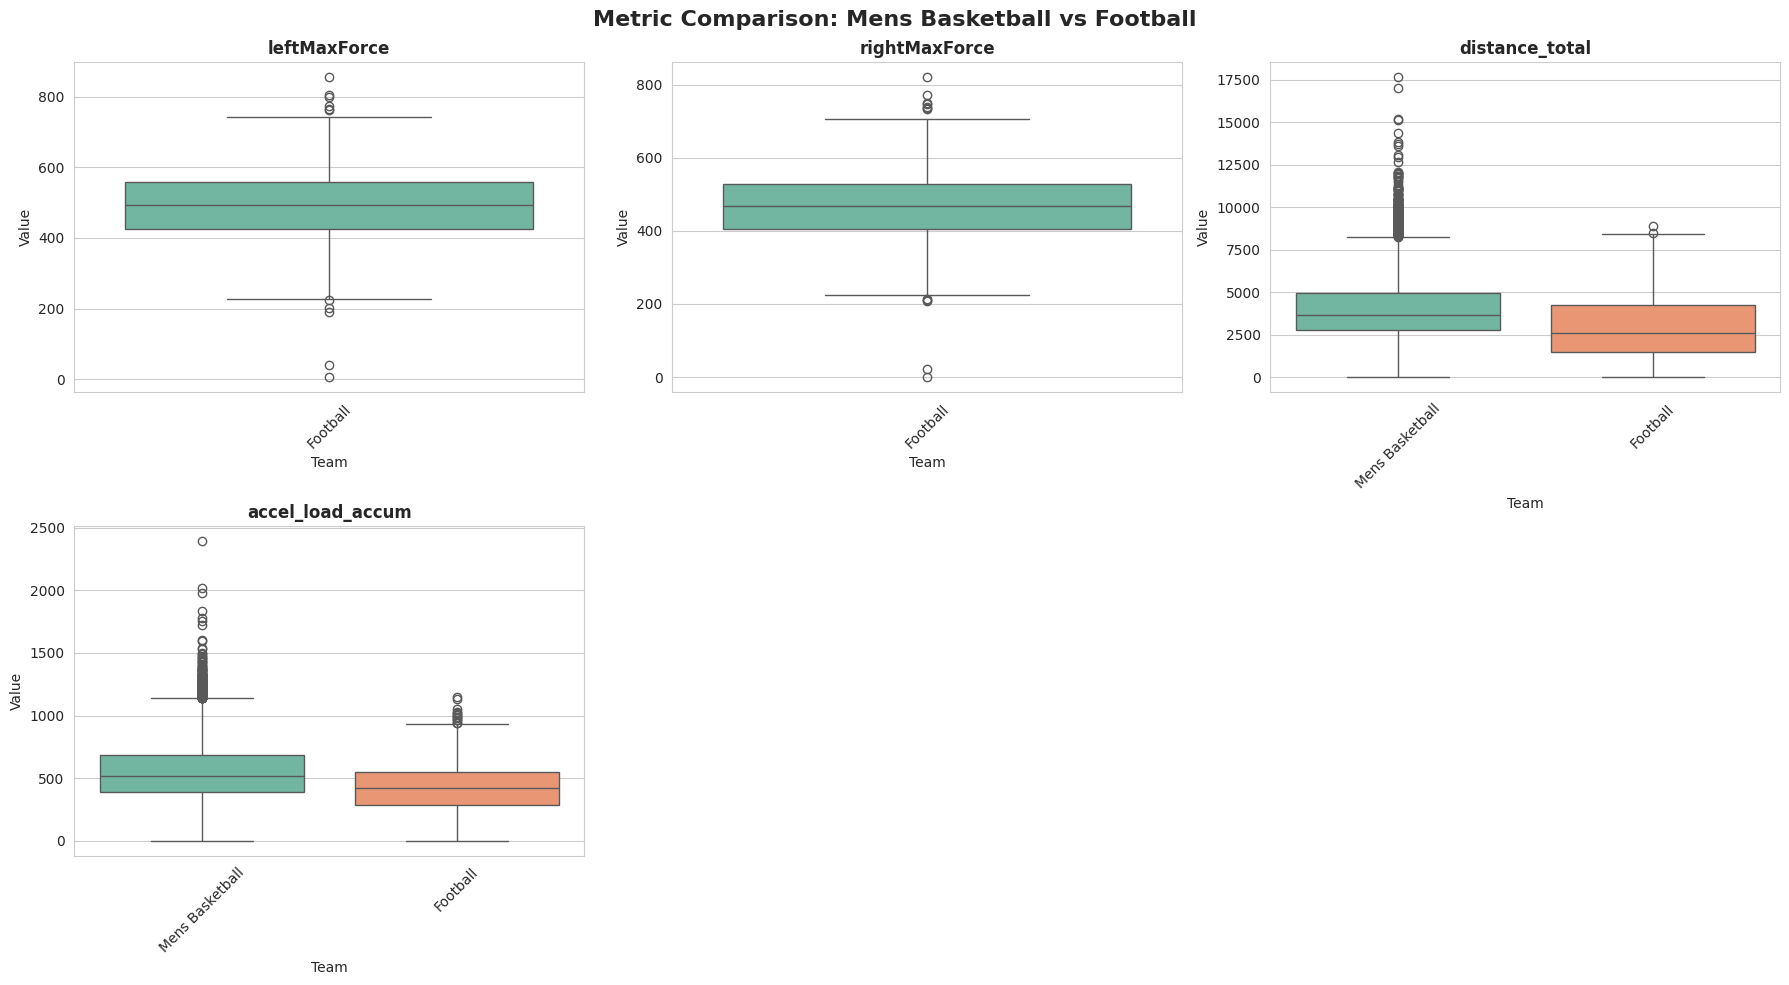

In [ ]:
# ========================================================================
# 1. GET LIST OF TEAMS
# ========================================================================

def get_team_list():
    """Get list of available teams with athlete count."""
    query = """
        SELECT DISTINCT team, COUNT(DISTINCT playername) as athlete_count
        FROM research_experiment_refactor_test
        WHERE metric IN (
            'accel_load_accum',
            'Jump Height(m)',
            'Peak Propulsive Force(N)',
            'distance_total',
            'leftMaxForce',
            'rightMaxForce'
        )
        GROUP BY team
        ORDER BY athlete_count DESC
    """
    return pd.read_sql(query, conn)

# Retrieve teams
df_teams = get_team_list()
print("\nAvailable Teams:")
print(df_teams.to_string(index=False))
print("\n")

# ========================================================================
# 2. SELECT TEAMS TO COMPARE
# ========================================================================

TEAM_1 = "Mens Basketball"
TEAM_2 = "Football"

print(f"Comparing: {TEAM_1} vs {TEAM_2}\n")

# ========================================================================
# 3. GET DATA FOR THE TWO TEAMS (SAFE QUERY)
# ========================================================================

def get_comparison_data(team1, team2):
    """Extract data for two teams safely using SQL parameters."""
    query = """
        SELECT
            playername,
            timestamp,
            metric,
            value,
            team
        FROM research_experiment_refactor_test
        WHERE team IN (%s, %s)
          AND metric IN (
              'accel_load_accum',
              'Jump Height(m)',
              'Peak Propulsive Force(N)',
              'distance_total',
              'leftMaxForce',
              'rightMaxForce'
          )
          AND value IS NOT NULL
        ORDER BY timestamp
    """
    return pd.read_sql(query, conn, params=(team1, team2))

df_comparison = get_comparison_data(TEAM_1, TEAM_2)

# ========================================================================
# 4. SUMMARY OUTPUT
# ========================================================================

print(f"Total records: {len(df_comparison)}")
print(f"\n{TEAM_1}: {len(df_comparison[df_comparison['team'] == TEAM_1])} records")
print(f"{TEAM_2}: {len(df_comparison[df_comparison['team'] == TEAM_2])} records\n")

# ========================================================================
# 5. BOX PLOTS
# ========================================================================

def create_boxplots(df, team1, team2):
    """Create box plots for all metrics comparing two teams."""

    metrics = df['metric'].unique()
    n_metrics = len(metrics)

    rows = (n_metrics + 2) // 3  # auto-expand rows if needed

    fig, axes = plt.subplots(rows, 3, figsize=(18, 5 * rows))
    fig.suptitle(f'Metric Comparison: {team1} vs {team2}', fontsize=16, fontweight='bold')

    axes = axes.flatten()

    for idx, metric in enumerate(metrics):
        df_metric = df[df['metric'] == metric]

        sns.boxplot(data=df_metric, x='team', y='value', ax=axes[idx], palette='Set2')
        axes[idx].set_title(metric, fontsize=12, fontweight='bold')
        axes[idx].set_xlabel('Team', fontsize=10)
        axes[idx].set_ylabel('Value', fontsize=10)
        axes[idx].tick_params(axis='x', rotation=45)

    # Turn off any leftover empty subplot boxes
    for j in range(len(metrics), len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.savefig("boxplot_comparison.png", dpi=300, bbox_inches="tight")
    print("✓ Box plots saved as 'boxplot_comparison.png'")
    plt.show()

create_boxplots(df_comparison, TEAM_1, TEAM_2)


In [ ]:
print("\n" + "="*80)
print("STATISTICAL SIGNIFICANCE TESTING")
print("="*80)

def perform_statistical_tests(df, team1, team2):
    """Perform t-tests for each metric between two teams"""

    results = []

    for metric in df['metric'].unique():
        df_metric = df[df['metric'] == metric]

        team1_data = df_metric[df_metric['team'] == team1]['value']
        team2_data = df_metric[df_metric['team'] == team2]['value']

        # Calculate descriptive statistics
        team1_mean = team1_data.mean()
        team1_std = team1_data.std()
        team1_n = len(team1_data)

        team2_mean = team2_data.mean()
        team2_std = team2_data.std()
        team2_n = len(team2_data)

        # Perform independent t-test
        t_stat, p_value = stats.ttest_ind(team1_data, team2_data, nan_policy='omit')

        # Effect size (Cohen's d)
        pooled_std = np.sqrt(((team1_n - 1) * team1_std**2 + (team2_n - 1) * team2_std**2) /
                             (team1_n + team2_n - 2))
        cohens_d = (team1_mean - team2_mean) / pooled_std if pooled_std > 0 else 0

        # Determine significance
        significance = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else "ns"

        results.append({
            'Metric': metric,
            f'{team1}_Mean': round(team1_mean, 2),
            f'{team1}_SD': round(team1_std, 2),
            f'{team1}_N': team1_n,
            f'{team2}_Mean': round(team2_mean, 2),
            f'{team2}_SD': round(team2_std, 2),
            f'{team2}_N': team2_n,
            'T-statistic': round(t_stat, 3),
            'P-value': round(p_value, 4),
            'Cohens_d': round(cohens_d, 3),
            'Significance': significance
        })

    df_results = pd.DataFrame(results)

    print("\nStatistical Test Results:")
    print("="*80)
    print(df_results.to_string(index=False))
    print("\nSignificance levels: *** p<0.001, ** p<0.01, * p<0.05, ns = not significant")
    print("\nCohen's d interpretation: 0.2=small, 0.5=medium, 0.8=large effect size")

    # Save results
    df_results.to_csv('statistical_tests_results.csv', index=False)
    print("\n✓ Statistical results saved as 'statistical_tests_results.csv'")

    return df_results

df_stats = perform_statistical_tests(df_comparison, TEAM_1, TEAM_2)


STATISTICAL SIGNIFICANCE TESTING

Statistical Test Results:
          Metric  Mens Basketball_Mean  Mens Basketball_SD  Mens Basketball_N  Football_Mean  Football_SD  Football_N  T-statistic  P-value  Cohens_d Significance
    leftMaxForce                   NaN                 NaN                  0         490.77       100.97        1001          NaN      NaN     0.000           ns
   rightMaxForce                   NaN                 NaN                  0         465.92        95.50        1001          NaN      NaN     0.000           ns
  distance_total               3885.44             2017.37               9224        2842.73      1738.17        9184       37.560      0.0     0.554          ***
accel_load_accum                534.23              259.67               9224         409.73       197.78        9184       36.582      0.0     0.539          ***

Significance levels: *** p<0.001, ** p<0.01, * p<0.05, ns = not significant

Cohen's d interpretation: 0.2=small, 0.5=mediu


TESTING FREQUENCY OVER TIME
✓ Testing frequency plot saved as 'testing_frequency_timeline.png'


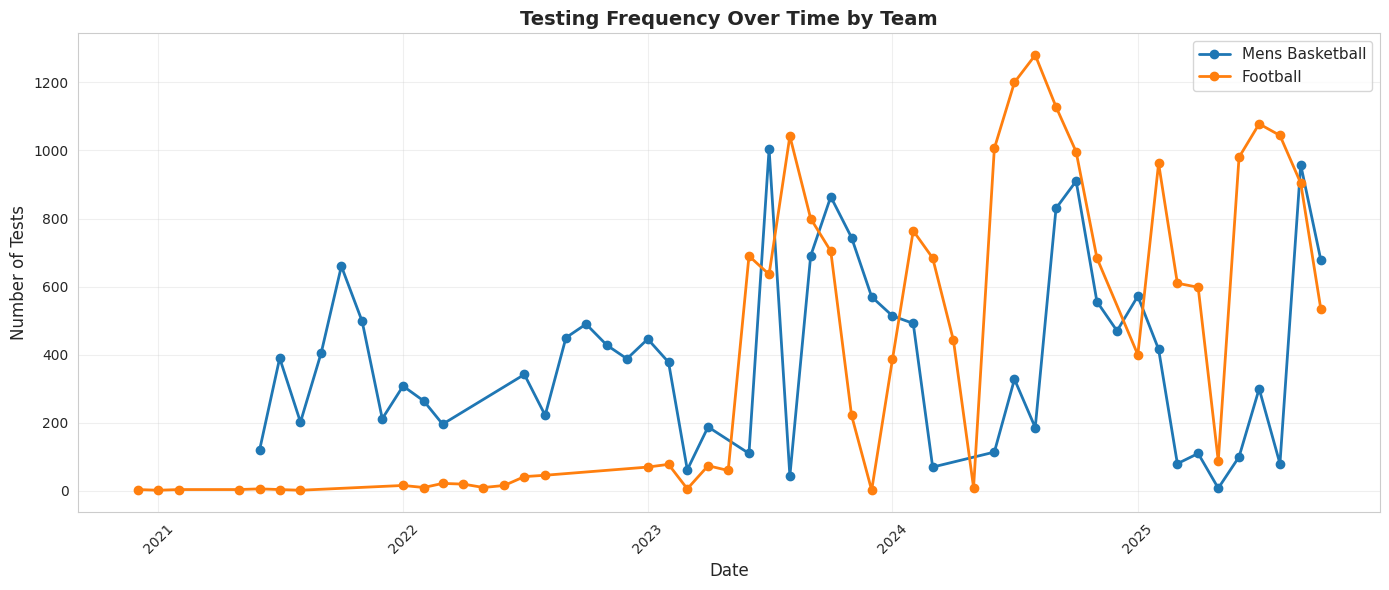

✓ Tests by metric plot saved as 'tests_by_metric_team.png'


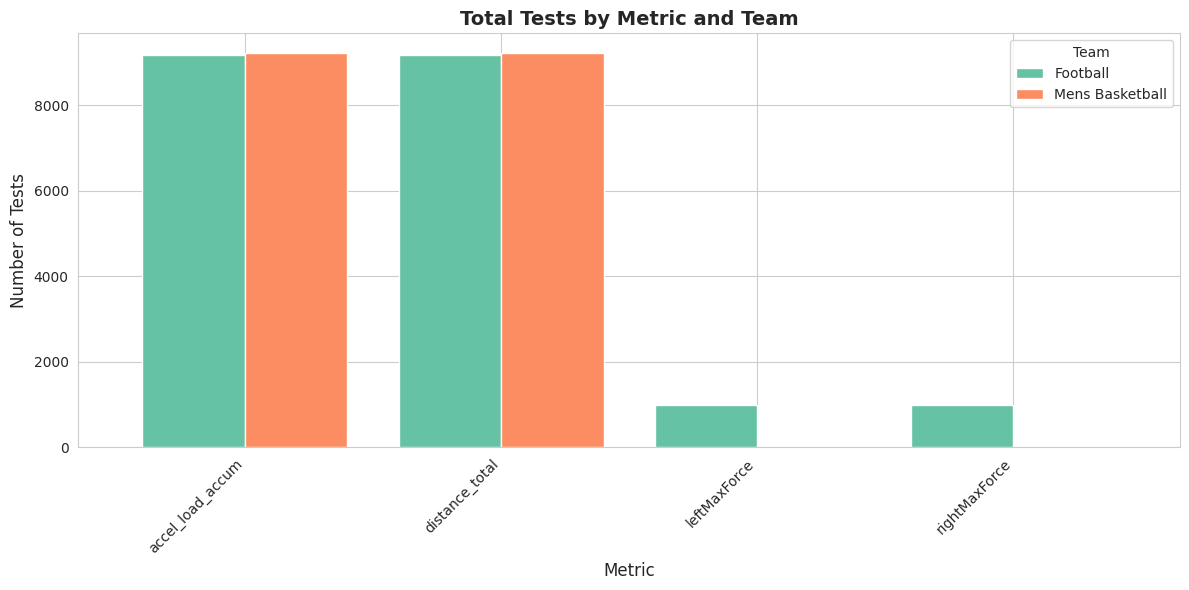

In [ ]:
print("\n" + "="*80)
print("TESTING FREQUENCY OVER TIME")
print("="*80)

def create_frequency_plot(df, team1, team2):
    """Visualize testing frequency by team over time"""

    # Convert timestamp to datetime
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['year_month'] = df['timestamp'].dt.to_period('M')

    # Count tests per month per team
    freq_data = df.groupby(['year_month', 'team']).size().reset_index(name='test_count')
    freq_data['year_month'] = freq_data['year_month'].dt.to_timestamp()

    # Create line plot
    plt.figure(figsize=(14, 6))

    for team in [team1, team2]:
        team_data = freq_data[freq_data['team'] == team]
        plt.plot(team_data['year_month'], team_data['test_count'],
                marker='o', label=team, linewidth=2, markersize=6)

    plt.title('Testing Frequency Over Time by Team', fontsize=14, fontweight='bold')
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Number of Tests', fontsize=12)
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('testing_frequency_timeline.png', dpi=300, bbox_inches='tight')
    print("✓ Testing frequency plot saved as 'testing_frequency_timeline.png'")
    plt.show()

    # Create bar chart by metric
    fig, ax = plt.subplots(figsize=(12, 6))

    metric_counts = df.groupby(['metric', 'team']).size().reset_index(name='count')
    metric_pivot = metric_counts.pivot(index='metric', columns='team', values='count')

    metric_pivot.plot(kind='bar', ax=ax, color=['#66c2a5', '#fc8d62'], width=0.8)
    plt.title('Total Tests by Metric and Team', fontsize=14, fontweight='bold')
    plt.xlabel('Metric', fontsize=12)
    plt.ylabel('Number of Tests', fontsize=12)
    plt.legend(title='Team', fontsize=10)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig('tests_by_metric_team.png', dpi=300, bbox_inches='tight')
    print("✓ Tests by metric plot saved as 'tests_by_metric_team.png'")
    plt.show()

create_frequency_plot(df_comparison, TEAM_1, TEAM_2)

In [ ]:
print("\n" + "="*80)
print("INTERPRETATION GUIDE")
print("="*80)

interpretation_template = f"""
INTERPRETATION OF RESULTS (Football vs Mens Basketball):

1. DO DIFFERENCES MAKE SENSE GIVEN SPORT DEMANDS?

   FOOTBALL DEMANDS:
   - High collision forces and contact
   - Explosive power for blocking, tackling, sprinting
   - Position-specific requirements (linemen vs skill positions)
   - Short bursts of maximal effort (3-7 seconds per play)
   - Emphasis on strength, power, and size

   MENS BASKETBALL DEMANDS:
   - Continuous movement up and down court
   - Frequent jumping for rebounding, blocking, shooting
   - Quick accelerations and decelerations
   - Longer duration of activity with brief rest periods
   - Emphasis on vertical power, speed, and agility

   EXPECTED DIFFERENCES:
   - Jump Height: Basketball should be HIGHER (jumping is fundamental)
   - Peak Propulsive Force: Football should be HIGHER (collision sport, power emphasis)
   - Distance Total: Basketball might be HIGHER (continuous movement)
   - Acceleration Load: Both should be high (different patterns)
   - Max Force: Football should be HIGHER (strength training emphasis)

2. COMPARISON TO PUBLISHED NORMS:

   JUMP HEIGHT:
   - Elite basketball players: 0.45-0.65m (18-26 inches)
   - Football skill positions: 0.40-0.55m (16-22 inches)
   - Football linemen: 0.30-0.45m (12-18 inches)

   PEAK PROPULSIVE FORCE:
   - Football athletes: >2500N (higher for linemen)
   - Basketball athletes: 2000-2500N
   - Power sports typically show higher values

   DISTANCE TOTAL (per session):
   - Basketball practice: 4000-6000m
   - Football practice: Varies by position (2000-5000m)

   Note: Check your literature review for sport-specific research studies

3. EXPLAINING DIFFERENCES/SIMILARITIES:

   FACTORS TO CONSIDER:
   - Position differences within teams (e.g., guards vs centers, linemen vs receivers)
   - Training emphasis (power vs endurance vs speed)
   - Sport-specific movements and demands
   - Testing timing (in-season vs off-season vs pre-season)
   - Sample size differences (Football: 136, Basketball: 99)
   - Athlete experience and competition level
   - Body composition differences between sports

   SPECIFIC CONSIDERATIONS:
   - Football data may show higher variance due to position diversity
   - Basketball players train specifically for vertical jump
   - Football emphasizes horizontal power (sprinting, blocking)
   - Testing consistency and frequency between teams

4. STATISTICAL SIGNIFICANCE:

   INTERPRETATION GUIDE:
   - P-value < 0.05: Statistically significant difference
   - P-value < 0.01: Highly significant
   - P-value < 0.001: Very highly significant

   EFFECT SIZE (Cohen's d):
   - 0.2 = Small effect (noticeable but minor difference)
   - 0.5 = Medium effect (moderate practical significance)
   - 0.8 = Large effect (substantial practical difference)

   KEY QUESTION: Is the difference both statistically significant AND practically meaningful?
   - Small p-value + large effect size = Strong evidence of real, meaningful difference
   - Small p-value + small effect size = Significant but may not be practically important
   - Large p-value = No evidence of difference (could be due to small sample or high variance)

5. LIMITATIONS TO CONSIDER:

   - Unequal sample sizes (Football: 136, Basketball: 99)
   - Position diversity within Football creates higher variance
   - Testing frequency differences between teams (check timeline plots)
   - Temporal bias: Were teams tested at different phases of training?
   - Missing data patterns may affect certain metrics more than others
   - Data quality and testing protocol consistency
   - Sample may not represent entire population of each sport
   - Cross-sectional data (not tracking individual changes over time)

6. CONNECTING TO LITERATURE:

   RESEARCH SUPPORT:
   - Cite studies comparing power athletes (football) vs skill athletes (basketball)
   - Reference sport-specific testing norms from your literature review
   - Discuss training adaptations specific to each sport
   - Consider biomechanical differences in movement patterns

   PRACTICAL APPLICATIONS:
   - How can these findings inform training programs?
   - Should testing protocols differ by sport?
   - What metrics are most important for each sport?
   - How can coaches use this data for athlete development?
"""

print(interpretation_template)

# Save interpretation template
with open('interpretation_guide.txt', 'w') as f:
    f.write(interpretation_template)
print("✓ Interpretation guide saved as 'interpretation_guide.txt'")


INTERPRETATION GUIDE

INTERPRETATION OF RESULTS (Football vs Mens Basketball):

1. DO DIFFERENCES MAKE SENSE GIVEN SPORT DEMANDS?

   FOOTBALL DEMANDS:
   - High collision forces and contact
   - Explosive power for blocking, tackling, sprinting
   - Position-specific requirements (linemen vs skill positions)
   - Short bursts of maximal effort (3-7 seconds per play)
   - Emphasis on strength, power, and size

   MENS BASKETBALL DEMANDS:
   - Continuous movement up and down court
   - Frequent jumping for rebounding, blocking, shooting
   - Quick accelerations and decelerations
   - Longer duration of activity with brief rest periods
   - Emphasis on vertical power, speed, and agility

   EXPECTED DIFFERENCES:
   - Jump Height: Basketball should be HIGHER (jumping is fundamental)
   - Peak Propulsive Force: Football should be HIGHER (collision sport, power emphasis)
   - Distance Total: Basketball might be HIGHER (continuous movement)
   - Acceleration Load: Both should be high (diffe

In [ ]:
print("\n" + "="*80)
print("ANALYSIS COMPLETE - SUMMARY")
print("="*80)

summary = f"""
FILES GENERATED:
1. boxplot_comparison.png - Box plots comparing metrics
2. violin_comparison.png - Distribution shapes for metrics
3. statistical_tests_results.csv - T-test results with effect sizes
4. testing_frequency_timeline.png - Testing frequency over time
5. tests_by_metric_team.png - Total tests by metric and team
6. interpretation_guide.txt - Framework for interpreting results

NEXT STEPS:
1. Review statistical significance in the CSV file
2. Identify which metrics show meaningful differences
3. Connect findings to your literature review
4. Write interpretation based on sport physiology
5. Consider limitations and context
"""

print(summary)


ANALYSIS COMPLETE - SUMMARY

FILES GENERATED:
1. boxplot_comparison.png - Box plots comparing metrics
2. violin_comparison.png - Distribution shapes for metrics
3. statistical_tests_results.csv - T-test results with effect sizes
4. testing_frequency_timeline.png - Testing frequency over time
5. tests_by_metric_team.png - Total tests by metric and team
6. interpretation_guide.txt - Framework for interpreting results

NEXT STEPS:
1. Review statistical significance in the CSV file
2. Identify which metrics show meaningful differences
3. Connect findings to your literature review
4. Write interpretation based on sport physiology
5. Consider limitations and context

